# Spatial indexing

This notebook discusses the notions spatial indexing. It starts with the notions of distance and neighborhood, and how the underlying calculations are performed using a direct or "brute force" approach. A second part is dedicated to the most found spatial structures: voxel grids, octree, and k-d trees.

In [1]:
# Necessary imports
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("./utils")
from plot_utils import cells_to_rect, plot_voxel

## Distance

The notion of distance $d$ is considered here as **the length between two points** noted $p$ and $q$. This is a measurement of "how far apart these two points are".

The most used and intuitive distance in our case is the Euclidean distance, which is defined by:
\begin{equation*}
d(p, q) = \sqrt{(p_x - q_x)^2 + (p_y - q_y)^2 + (p_z - q_z)^2}
\end{equation*}

As shown below, it corresponds to a straight line between points.

The Euclidean distance between these two points is equal to: 69.7


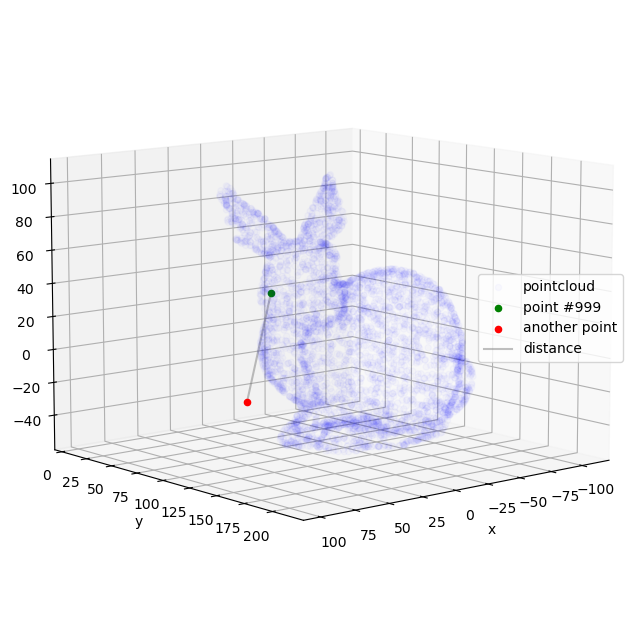

In [2]:
# Load pointcloud
points = np.loadtxt("./data/stanford_bunny_simple.xyz")
# Create another point
another_point = np.array([90., 150., -10.])
# Distance
point_999 = points[999]
dist = np.linalg.norm(point_999 - another_point) # this is equivalent to np.sqrt(np.sum((point_99 - point_other)**2))
print("The Euclidean distance between these two points is equal to: {:.1f}".format(dist))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
          color="blue", alpha=0.02, label="pointcloud")
ax.scatter(point_999[0], point_999[1], point_999[2],
          color="green", label="point #999")
ax.scatter(another_point[0], another_point[1], another_point[2],
          color="red", label="another point")
ax.plot([another_point[0], point_999[0]], [another_point[1], point_999[1]], [another_point[2], point_999[2]],
          color='gray', alpha=0.5, label="distance")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 50)
plt.axis("equal")
plt.show()


However, note that in a *metric space*, such as the 3-dimensional Euclidean space considered here, a distance is merely a function satisfying the following conditions:
* positivity $d(a, b) \geq 0$
* symmetry $d(a, b) = d(b, a)$
* separation $d(a, b) = 0 \iff a = b$
* triangular inequality $d(a, c) \leq d(a, b) + d(b, c)$

As consequence, other types of distance might be encountered, such as the *taxicab* or *Manhattan* or 1-distance, given by:
\begin{equation*}
d_{1}(p, q) = |p_x - q_x| + |p_y - q_y| + |p_z - q_z|
\end{equation*}
or the *Chebyshev* or *maximum* or $\infty$-distance, given by:
\begin{equation*}
d_{\infty}(p, q) = \max(|p_x - q_x|, |p_y - q_y|, |p_z - q_z|)
\end{equation*}

The Euclidean distance mentioned earlier is also called the 2-distance. For higher numbers, distance is referred to as *Minkowski* or $p$-distance.

Note also that distances may be expressed as norms such as $d_{n}(p, q) = ||p - q||_{n}$ (in practice, if $n$ is omitted you can consider that this is the Euclidean distance).

## Neighborhood

The notion of neighborhood is roughly defined as **the set of points in the vicinity of a query point** (noted $q$). Two types of neighborhood are considered in practice: those with a fixed distance and those with a fixed number of points.

The first one is called a *spherical* neighborhood (and the associated search is often referred to as *ball query*), as all points within a radius $r$ of $q$ are selected:
\begin{equation*}
N_{r}(q) = \{ p \in P : d(p, q) < r \}
\end{equation*}

Unlike the first one, for which the number of neighbors is not known in advance, the second neighborhood results in a fixed-size set of the $k$-nearest-neighbors of $q$ or knn.

Let's see now how neighborhoods may be computed in practice!

In [3]:
# Define the query point for the rest of the notebook
query_point = another_point
# Set the parameters k and r for the rest of the notebook
k = 5
r = 50


## The "brute force" approach

The most immediate approach for computing neighborhoods is called the "brute force approach".

It is fairly simple and only consists in a few steps:
1. Computing the distance between the query point and all the points of the pointcloud
2. Sorting the points by distance to the query point
3. Selecting the $k$ closest points or points within a distance inferior to the search radius $r$

An example is given below.

Closest 5 points of the pointcloud to 'another point' are points # [ 183  893 3550   53  221]
Points within r are points # [  53  183  221  268  287  436  449  893 1135 1342 1402 1900 1952 2002
 2014 2216 2369 2399 3106 3550 3663 4021 4057]


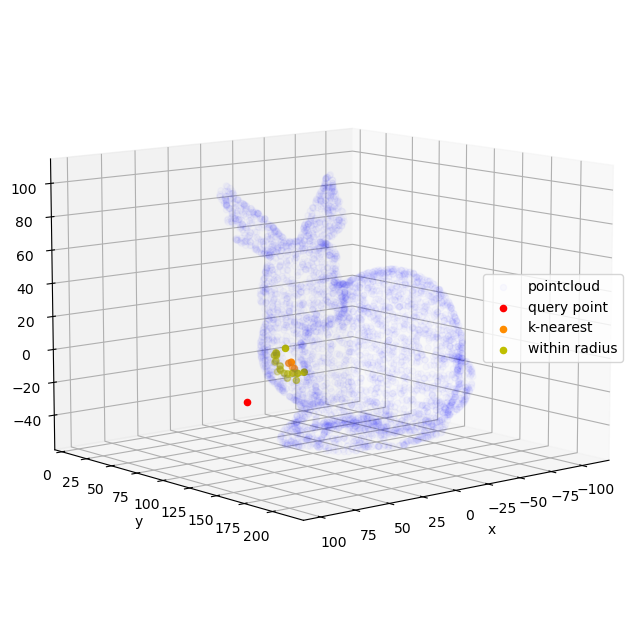

In [4]:
def brute_force_search(points, query_point, k):

    # Compute distances to the query point
    dists = np.linalg.norm(points - query_point, axis=1)
    # Sort the points by distance
    sorted_inds = np.argsort(dists)
    # Select the k closest points
    return sorted_inds[:k]

def brute_force_ball_search(points, query_point, r):

    # Compute distances to the query point
    dists = np.linalg.norm(points - query_point, axis=1)
    # Sort the points by distance
    sorted_inds = np.argsort(dists)
    # Select points within a radius r
    return np.argwhere(dists < r).flatten()

# Try brute force search
knn_brute_force = brute_force_search(points, query_point, k)
with np.printoptions(precision=2, suppress=True):
    print("Closest 5 points of the pointcloud to 'another point' are points #", knn_brute_force)

# Try brute force ball search
ball_seach_brute_force = brute_force_ball_search(points, query_point, r)
print("Points within r are points #", ball_seach_brute_force)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
          color="blue", alpha=0.02, label="pointcloud")
ax.scatter(query_point[0], query_point[1], query_point[2],
          color="red", label="query point")
ax.scatter(points[knn_brute_force, 0], points[knn_brute_force, 1], points[knn_brute_force, 2],
          color="darkorange", label="k-nearest")
ball_seach_brute_force_fig = np.setdiff1d(ball_seach_brute_force, knn_brute_force) # do not repeat points
ax.scatter(points[ball_seach_brute_force_fig, 0], points[ball_seach_brute_force_fig, 1], points[ball_seach_brute_force_fig, 2],
          color="y", label="within radius")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 50)
plt.axis("equal")
plt.show()


While conceptually simple, note that this approach is however quite inefficient.

Indeed it basically requires to compute the distance between the query point and each point of the pointcloud. This results in $n^2$ calculations in case that a neighborhood needs to be computed for each point of a pointcloud of size $n$ (which is often needed for estimating local properties such as normals or curvatures). Thus **the brute force approach is not recommended for large pointclouds** (typically starting from a few thousands of points).

We can see that the main source of inefficiency of this approach lies in the fact that distances are systematically computed, irrespective of how far apart points may be. That's why the idea of using data structures based on the points position came into play.

## Spatial structures

The idea that lies behind spatial structures is quite intuitive: **partitioning the 3D space in different "regions" that contain a subset of the pointcloud**. The notion of region helps to guide the neighborhood search by focusing only on the points that are "close enough" to the query point (disregarding the others that are "too far").


### Voxel grid

A first and quite simple way to partition the 3D space around a pointcloud is to use a *regular grid*. This grid is said to be regular if it consists of cells (or "chunks") of equal size, which corresponds to cubes or *voxels* in a three-dimensional space. The word voxel comes from the fusion between volume and pixel and is thus to 3D what a pixel is to 2D. **A voxel grid is then a set of voxels that contain the points of the pointcloud**.

In practice, using a voxel grid may be seen as putting points into numbered cubic boxes. The search for neighbors then becomes easier as it is limited to looking into a limited number of boxes (i.e., voxels) around the one containing the query point (think about a cabinet with drawers).

Let's see now how voxel grids may be built in practice!

In [5]:
# Set the cell size for the rest of the notebook
cell_size = 20.

A prior step into building a voxel grid is to define a consistent way to name or number the voxels. There are of course many possibilities, but a simple one consists in using the position of its bottom-left corner on the grid. For example, for a voxel size of $20$ (edges have a length of 20), a voxel numbered $(1, 2, 3)$ would start at position $[1, 2, 3]$ on the grid, which correspond to position $[20., 40., 60.]$ in the main coordinate system.

Once the naming convention has been defined, the voxel grid can be built using the following steps:
1. Associate each point of the pointcloud to a voxel, that is $p_i \in V_{(a, b,c)}$
2. Fill the voxels with the points, that is $V_{(a, b, c)} = \{p_i, p_j, ...\}$

There are also several type of data structure that may be used to build a voxel grid in practice. A simple way consists in using a *hash table* or a *dictionary*, with the *keys* being the identifiers of the voxels (name or number) and the *values/buckets* being the list of the points they contain. In practice, it is easier to store the point indices into the voxels (rather than the points coordinates) to simplify the update if the pointcloud is altered (addition or removal of points). Note that empty voxels (i.e., voxels that do not contain any points) are not explicitly represented (stored) using this technique.

Let's illustrate this with a 2D example first!

Point # 0 with coordinates [-25.5861  42.684 ] is associated with cell # [(-2, 2)]
Cell # (-2, 2) contains points # [0, 72, 73, 128, 153, 197, 203, 283, 449, 470]


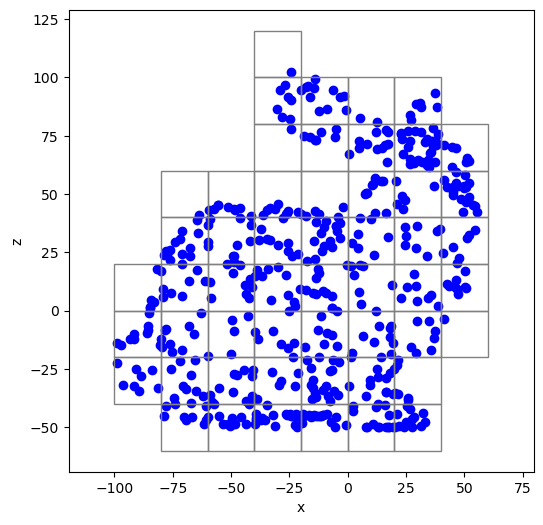

In [6]:
def points_to_cells(points, cell_size):

    # Works also for individual points
    if points.ndim==1: 
        points = points.reshape((1, -1))
    # Bottom-left corner position on the grid
    cell_coords = (points//cell_size).astype(int)
    # Lists or arrays cannot be dict keys so we use tuples instead
    return [tuple(c) for c in cell_coords]

def create_cell_grid(points, cell_size):

    # Associate each point to a cell
    cell_coords = points_to_cells(points, cell_size)
    # Create a dict with {coord:[points]}
    cell_grid = {}
    for i, coord in enumerate(cell_coords):
        cell = cell_grid.setdefault(coord, []) # create the cell if it does not already exist
        cell.append(i) # store point index in the cell
    
    return cell_grid

# Create a 2D pointcloud
points_sample_2d = points[::8, [0,2]] # keep one 8th of points and only the x and z coordinates

# Check the first point
print(f"Point # {0} with coordinates {points_sample_2d[0]} is associated with cell # {points_to_cells(points_sample_2d[0], cell_size)}")

# Create a 2D grid (of squares/pixels)
cell_grid_2d = create_cell_grid(points_sample_2d, cell_size)
# Check the first voxel
print("Cell # {} contains points # {}".format(*list(cell_grid_2d.items())[0]))

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(points_sample_2d[:, 0], points_sample_2d[:, 1],
          color="blue")
rectangles = cells_to_rect(cell_grid_2d, cell_size)
for rect in rectangles:
    ax.add_patch(rect)
ax.set_xlabel('x')
ax.set_ylabel('z')
plt.axis("equal")
plt.show()


The process is exactly the same in 3D.

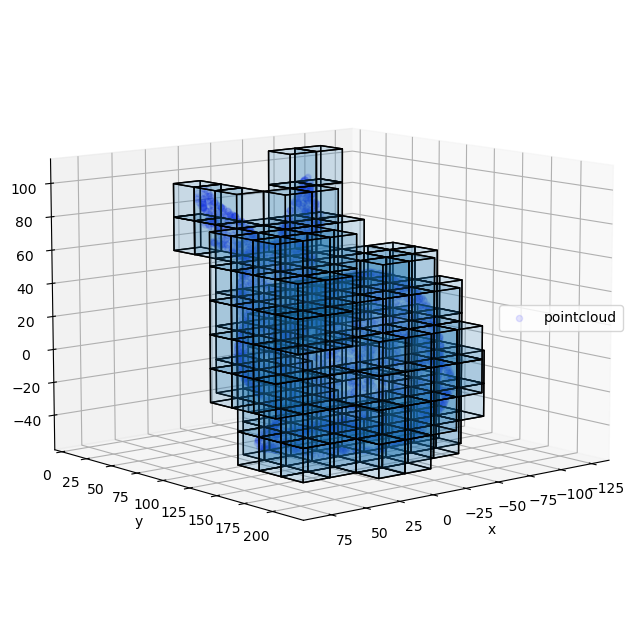

In [7]:
# Build voxel grid
cell_grid_3d = create_cell_grid(points, cell_size)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
          color="blue", alpha=0.1, label="pointcloud")
pc = plot_voxel(cell_grid_3d.keys(), cell_size, edgecolor="k", alpha=0.1)
ax.add_collection3d(pc)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 50)
plt.axis("equal")
plt.show()


Note that **a voxel grid constitutes a kind of 3D representation in itself**, just like a pointcloud or a mesh. Voxels grids are typically used in areas such as volumetric imaging (in medicine or materials science), video games or simulation.

As mentioned before, a parallel can be drawn between voxels grids and images, which are respectively 3D and 2D regular grids. Just like images, voxels grids may have different channels for colors (such as red, green, and blue), but also for other types of information.

Continuing with our parallel, note that a square image of one megapixel (i.e., one million pixels) would have a shape of $(1000*1000)$ while an "image" of one "megavoxel" would have a shape of $(100*100*100)$. It means that high-resolution and dense (i.e., without empty voxels) voxel grids are usually quite heavy to store and process. The fact that adding an extra dimension (from 2D to 3D) results in increasing dramatically the data volume is called *the curse of dimensionality*.

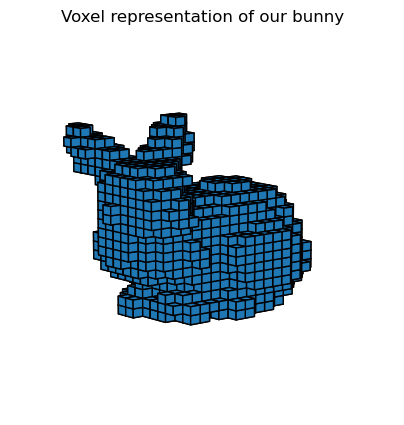

In [8]:
def voxelize_pointcloud(points, grid_length):

    # Deduce the appropriate voxel size
    cell_size = points.ptp(axis=0).max() / grid_length
    # Compute voxels
    voxel_rep = np.unique((points//cell_size).astype(int), axis=0)
    # Make sure that voxels have positive coordinates (similar to pixels in images)
    voxel_rep -= voxel_rep.min(axis=0)

    return voxel_rep, cell_size

# Choose the number of voxels in each direction (x, y, and z)
grid_length_rep = 20
# Voxelize
voxel_rep, cell_size_rep = voxelize_pointcloud(points, 20.)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection="3d")
pc = plot_voxel(voxel_rep, cell_size_rep, edgecolor="k")
ax.add_collection3d(pc)
ax.set_xlim(right=cell_size_rep*grid_length_rep)
ax.set_ylim(top=cell_size_rep*grid_length_rep)
ax.set_zlim(top=cell_size_rep*grid_length_rep)
ax.view_init(10, 50)
ax.set_axis_off()
ax.set_title("Voxel representation of our bunny")
plt.show()


Voxel grids may also be used for other purposes such as subsampling.

As explained in the first notebook, subsampling aims to decrease the size of the pointcloud. An approach consists in selecting points to keep/remove at random, but this gives in a very irregular resulting pointcloud. On the other hand, it is possible to rely on spatial structures to achieve more regular results.

As often, several options may be considered. A first one would consist in selecting one or a few points per voxel. These points can be selected at random, or according to any other rule (e.g., the closest points to the voxel center). Another option consists in replacing the points in each voxel by a unique point that would summarize their properties. We can think for example of averaging the points coordinates (position, but also colors and so on). Note that in the second option, the original pointcloud is rather "simplified" than subsampled.


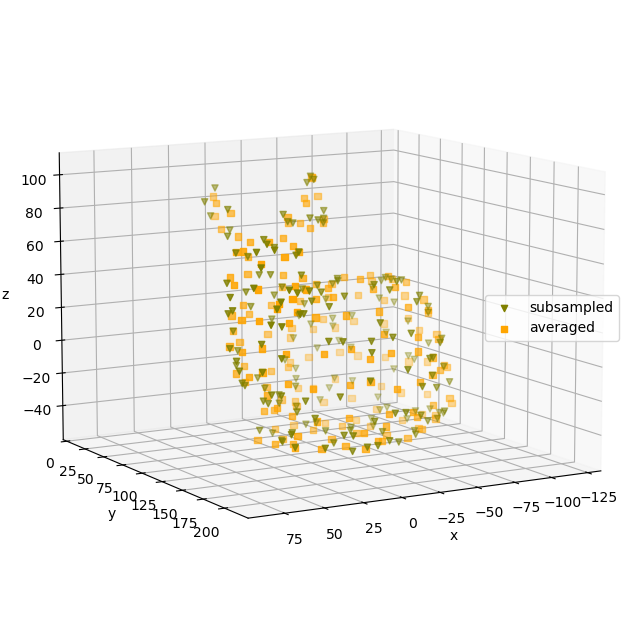

In [9]:
def subsample_grid(points, cell_grid):

    random_inds = np.array([np.random.choice(inds) for inds in cell_grid.values()])
    
    return points[random_inds]

def average_grid(points, cell_grid):

    avg_points = np.array([points[inds].mean(axis=0) for inds in cell_grid.values()])
    
    return avg_points

# Try subsample
points_grid_sub = subsample_grid(points, cell_grid_3d)

# Try average
points_grid_avg = average_grid(points, cell_grid_3d)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_grid_sub[:, 0], points_grid_sub[:, 1], points_grid_sub[:, 2],
           c='olive', marker="v", label="subsampled")
ax.scatter(points_grid_avg[:, 0], points_grid_avg[:, 1], points_grid_avg[:, 2],
           c='orange', marker="s", label="averaged")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()


After this digression, let's return to the neighborhood search!

As stated before, the main advantage in using a spatial structure is that the search is limited only to points that are not "too far away" from the query point. In this case, these points would be contained in **the voxels that are the closest to the query point**.

In practice, one option consists in determining the voxel coordinates associated with the query point (i.e., the voxel in which the query point "would fall", whether this voxel already contains points or not) and computing the distance with the other voxels in the voxel grid.

But how to define distance between voxels? Consider a 2D pixel, its immediate neighborhood is composed of 8 cells (cardinal directions NW, N, NE, W, E, SW, S, and SE). A 3D voxel has then 26 (8 + 9 + 9) immediate neighbors. We may refer to these neighborhoods as 1-neighborhoods and extend this reasoning to superior orders (i.e., 2-neighborhoods, 3-neighborhoods, etc.). Note this is distantly linked to the concept of *Moore neighborhood* used in cellular automata theory. In this case, using the grid coordinates defined earlier, the $p$-neighborhood of a given cell is made up of cells located at a Chebyshev distance of $p$.

This idea is implemented below.

In [10]:
def cell_neighborhoods(query_cell, cells, max_range=np.inf):
    """Categorize cells by distance to the query_cell (with optional limit)"""

    # Make sure to use Numpy arrays to speed-up calculations
    query_cell = np.asarray(query_cell, dtype=int)
    cells = np.asarray([*cells], dtype=int)
    # Chebyshev distance
    dists = np.linalg.norm(query_cell - cells, ord=np.inf, axis=1)
    # Easier stored using a dict
    neighborhoods = {}
    for d, c in zip(dists, cells):
        if d > max_range: continue
        cell = neighborhoods.setdefault(int(d), [])
        cell.append(tuple(c))

    return neighborhoods

# Example
query_cell_ex = (0, 0, 0)
cells_ex = [(i, j, k) for i in range(-2, 3) for j in range(-2, 3) for k in range(-2, 3)] # create a voxel grid of size (5*5*5) centered around (0, 0, 0)
p_neighborhoods_ex = cell_neighborhoods(query_cell_ex, cells_ex)
print("The 1-neighborhood of cell", query_cell_ex, "is composed of cells :", p_neighborhoods_ex.get(1))


The 1-neighborhood of cell (0, 0, 0) is composed of cells : [(-1, -1, -1), (-1, -1, 0), (-1, -1, 1), (-1, 0, -1), (-1, 0, 0), (-1, 0, 1), (-1, 1, -1), (-1, 1, 0), (-1, 1, 1), (0, -1, -1), (0, -1, 0), (0, -1, 1), (0, 0, -1), (0, 0, 1), (0, 1, -1), (0, 1, 0), (0, 1, 1), (1, -1, -1), (1, -1, 0), (1, -1, 1), (1, 0, -1), (1, 0, 0), (1, 0, 1), (1, 1, -1), (1, 1, 0), (1, 1, 1)]


Now that distances between cells can be computed, let's go back to the k-nearest neighbors' search!

The most straightforward approach is the following, considering a target point:
1. Determining in which voxel this point falls
2. Looking within the neighboring voxels while increasing the order/distance $p$
3. Stopping when the target number of points $k$ is reached
4. Including the $p+1$-neighborhood (to make sure that no points are missed)
5. Performing a brute-force search on the points included in the neighboring voxels


In [11]:
def grid_search(points, cell_grid, query_point, k):

    # Determine in which cell the query point falls
    query_cell = (query_point//cell_size).astype(int)
    
    # Compute the query cell neighborhoods
    query_cell_neighborhoods = cell_neighborhoods(query_cell, cell_grid.keys())
    
    # Incrementally explore the cell neighborhoods
    candidate_inds = []
    # Increase the distance p at each step
    for p in sorted(query_cell_neighborhoods.keys()):
        # Add the points indices contained in the cells
        for neighboring_cell in query_cell_neighborhoods[p]:
            candidate_inds.extend(cell_grid[neighboring_cell])
        
        # Stop when the target number of points is reached
        if len(candidate_inds) >= k:
            for neighboring_cell in query_cell_neighborhoods[p+1]:
                candidate_inds.extend(cell_grid[neighboring_cell])
            candidate_inds = np.asarray(candidate_inds)
            break
    
    # Perform a brute force search
    closest_candidates = brute_force_search(points[candidate_inds], query_point, k)
    
    return candidate_inds[closest_candidates]

# Using our example
knn_voxel_grid = grid_search(points, cell_grid_3d, query_point, k)
with np.printoptions(precision=2, suppress=True):
    print("Closest 5 points of the pointcloud to 'another point' are points #", knn_voxel_grid)
print("knn are the same than those computed with brute force:", not np.setdiff1d(knn_voxel_grid, knn_brute_force).size)


Closest 5 points of the pointcloud to 'another point' are points # [ 183  893 3550   53  221]
knn are the same than those computed with brute force: True


For ball search, the most straightforward approach is the following, considering a target point:
1. Determining in which voxel this point falls
2. Determining the voxels that are within the radius $r$
3. Performing a brute-force search on the points included in the neighboring voxels


In [12]:
def grid_ball_search(points, cell_grid, cell_size, query_point, r):

    # Determine in which cell the query point falls
    query_cell = (query_point//cell_size).astype(int)
    
    # Compute the query cell neighborhoods
    max_range = r//cell_size + 1
    p_neighborhoods = cell_neighborhoods(query_cell, cell_grid_3d.keys(), max_range)
    cells_within_max_range = [cell for p_cells in p_neighborhoods.values() for cell in p_cells]

    # Add the points indices contained in the cells
    candidate_inds = np.array([inds for cells in cells_within_max_range for inds in cell_grid_3d[cells]])

    # Perform a brute force search
    inds_within_r = brute_force_ball_search(points[candidate_inds], query_point, r)

    return candidate_inds[inds_within_r]

# Using our example
ball_seach_voxel_grid = grid_ball_search(points, cell_grid_3d, cell_size, query_point, r)
print("Points within r are points #", ball_seach_voxel_grid)
print("Points within r are the same than those computed with brute force:", not np.setdiff1d(ball_seach_voxel_grid, ball_seach_brute_force).size)


Points within r are points # [  53  183  221  436  449  893 1135 1342 1402 1952 2216 2399 3663  268
  287 1900 2002 2014 2369 3106 3550 4057 4021]
Points within r are the same than those computed with brute force: True


It's easy to see why using a voxel grid is in theory more efficient than a brute force approach, as only a fraction of the initial pointcloud is considered during the search.

There is however **a major parameter to consider, that is the voxels size**. Remember that it was the only parameter used to build our voxel grid.

Let's see how this size affects the speed of the neighborhood search!

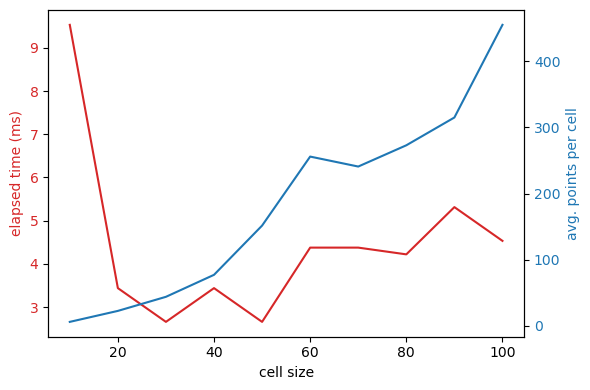

In [13]:
# Try different grid sizes
sizes = [s for s in range(10, 110, 10)]
# Measure time for knn search and average number of points per cell
elapsed_time = []
points_per_cell = []
for s in sizes:
    # Time for grid creation is not considered
    grid = create_cell_grid(points, s)
    points_per_cell.append(np.mean([len(c) for c in grid.values()]))
    # Consider multiple runs
    elapsed_time_runs = []
    for _ in range(1000):
        start_time = time.process_time()
        grid_search(points, grid, query_point, k)
        end_time = time.process_time()
        elapsed_time_runs.append(end_time-start_time)
    elapsed_time.append(np.mean(elapsed_time_runs)*10e3)

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot()
ax1.set_xlabel("cell size")
ax1.set_ylabel('elapsed time (ms)', color='tab:red')
ax1.plot(sizes, elapsed_time, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1.twinx()
ax2.set_ylabel('avg. points per cell', color="tab:blue")
ax2.plot(sizes, points_per_cell, color="tab:blue")
ax2.tick_params(axis='y', labelcolor="tab:blue")
fig.tight_layout()
plt.show()


Even if the right part is less steep (due to the smallness of the considered pointcloud), we can clearly see a "U-shape" curve for the elapsed time. On the left part, the number of voxels that are necessary to consider during the search is too high to offer a significant speed-up (imagine the extreme case of only one point per voxel, this is equivalent to a brute-force search among points). On the right time, only a few voxels are considered, but they contain a large portion of the pointcloud (imagine the extreme case of only one voxel containing the entire pointcloud, this is again equivalent to a brute-force search among points).

It is then paramount to choose the correct voxels size so that the neighbors search is as efficient as possible. As a rule of thumb, **begin with voxel size giving about 50 points per voxel on average at first**, and try other sizes from there. However, the correct size is also highly dependent of the average number of neighbors to query or the radius size, this is not an exact science.

To sum up, voxel grids are a nice kind of spatial structure but suffer some limitations. That is why hierarchical structures are preferred in practice.